References:
    * https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec# 

## Load

In [1]:
import json

In [2]:
raw_data = json.load(open('example.dialog.json', 'r'))['rasa_nlu_data']['common_examples']

In [3]:
import pandas as pd

In [4]:
data = pd.DataFrame(raw_data)

In [5]:
%matplotlib inline

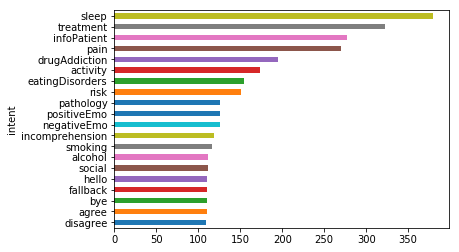

In [6]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

## Preprocess

### Tokenize the text

In [7]:
import nltk, re

In [8]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [9]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(data)

### Clean the text

In [10]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    #stopwords = nltk.corpus.stopwords.words('english')
    
    with open('long-stop-en.txt', 'r') as f:
        stopwords = list(map(lambda x: x.strip(), f.readlines()))

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(data)

In [11]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(data)

In [12]:
from gensim.corpora import Dictionary

In [13]:
dictionary = Dictionary(documents=data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 1880 words.


In [14]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(data)

In [15]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

### Plot

In [16]:
from collections import Counter

In [17]:
import numpy as np

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

In [19]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [20]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

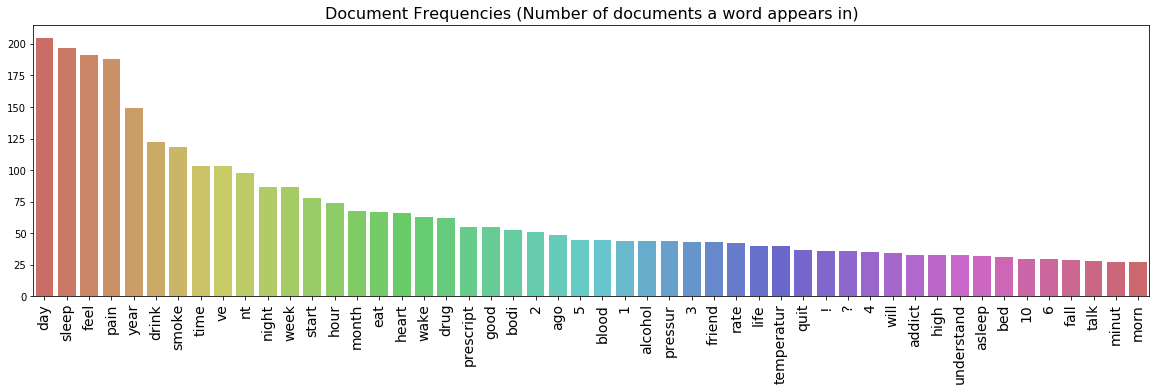

In [21]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

## W2V features

In [22]:
sentences = []
for sentence_group in data.text:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(data)))

Number of sentences: 107198.
Number of texts: 3307.


In [23]:
from gensim.models import Word2Vec

In [24]:
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [25]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    try:
        words = sentence_group  # words in text
    except:
        print(sentence_group)
        words = np.concatenate([['']])  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.text))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## Pretrained embeddings

In [26]:
import gensim.downloader as api

In [27]:
info = api.info()

In [28]:
model = api.load("glove-twitter-25")

In [ ]:
model = api.load("word2vec-google-news-300")

### test

In [299]:
model.most_similar("sleep")

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wake', 0.9654639959335327),
 ('tired', 0.9245999455451965),
 ('feel', 0.9237402081489563),
 ('awake', 0.9227220416069031),
 ('sleeping', 0.9174003601074219),
 ('alone', 0.9170509576797485),
 ('too', 0.9083741307258606),
 ('asleep', 0.9069899320602417),
 ('sigh', 0.9062435030937195),
 ('ill', 0.9025631546974182)]

In [300]:
data['glove_features'] = list(map(lambda sen_group:
                                      get_w2v_features(model, sen_group),
                                      data.text))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', 
                                                        binary=True) 

In [ ]:
model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

## LDA features

In [29]:
from gensim.models import LdaModel, LdaMulticore

In [30]:
corpus = data.bow

In [31]:
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [32]:
LDAmodel.top_topics(corpus=corpus)[5]

([(0.15730013, 'cut'),
  (0.07659871, 'health'),
  (0.062004924, 'men'),
  (0.06052336, 'excus'),
  (0.046628833, 'placquenil'),
  (0.046628833, 'hydroxi'),
  (0.046622198, 'continu'),
  (0.03584725, 'sleep'),
  (0.031252738, 'bad'),
  (0.031252734, '60'),
  (0.031252734, 'tremor'),
  (0.031252734, 'experienc'),
  (0.031252734, 'year'),
  (0.031252734, 'excel'),
  (0.0310322, 'paralysi'),
  (0.031030765, 'odd'),
  (0.015876643, 'fatigu'),
  (0.002635476, 'appetit'),
  (0.0023341097, 'eat'),
  (0.0011227392, 'good')],
 -15.266539018274836)

In [33]:
def document_to_lda_features(lda_model, document):
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))

## HDP modeling

In [38]:
from gensim.models import HdpModel

In [ ]:
list(filter(lambda x: len(x) > 0, corpus))

In [148]:
hdp = HdpModel(corpus=list(filter(lambda x: len(x) > 0, corpus)), id2word=dictionary)

In [155]:
hdp.print_topics()

[(0,
  '0.003*ritonavir + 0.003*infect + 0.003*amikacin + 0.003*ach + 0.003*climb + 0.003*94 + 0.003*rigor + 0.003*wheelchair + 0.003*heat + 0.003*group'),
 (1,
  '0.003*19 + 0.003*patch + 0.003*moral + 0.003*whilst + 0.003*today + 0.003*cant + 0.003*desper + 0.002*affirm + 0.002*deeper + 0.002*special'),
 (2,
  '0.004*suboxon + 0.003*tall + 0.003*coricidin + 0.003*aaaaaaazz + 0.003*120mg + 0.003*learn + 0.003*exerciseinduc + 0.003*hydroxychloroqin + 0.003*pessimist + 0.003*shut'),
 (3,
  '0.004*190 + 0.004*bloodi + 0.003*80 + 0.003*cee + 0.003*rest + 0.003*switch + 0.003*39 + 0.003*middlenam + 0.003*hope + 0.003*sunday'),
 (4,
  '0.005*diagnosi + 0.004*98976f + 0.004*system + 0.004*old + 0.003*fatigu + 0.003*use + 0.003*chain + 0.003*half + 0.003*swallow + 0.003*decid'),
 (5,
  '0.005*coricidin + 0.004*start + 0.003*diet + 0.003*squeez + 0.003*10325 + 0.003*fiber + 0.003*day + 0.003*jog + 0.003*coke + 0.003*remicad'),
 (6,
  '0.004*tender + 0.003*done + 0.003*swollen + 0.003*cefalexin

kind of mess

## Dataset

In [34]:
X_lda = np.array(list(map(np.array, data.lda_features)))
X_w2v = np.array(list(map(np.array, data.w2v_features)))

In [ ]:
X_glove = np.array(list(map(np.array, data.glove_features)))
#X_combined = np.append(
X_combined = np.append(X_lda, X_w2v, axis=1)
#, X_glove, axis=1)

In [32]:
X_train_combined.shape

(3307, 350)

## Clustering

In [36]:
K = len(data['intent'].unique())

In [37]:
X = X_lda
y = data['intent']

---

In [38]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [39]:
from sklearn.mixture import GaussianMixture

In [40]:
km = KMeans(K).fit(X)

In [310]:
km = AgglomerativeClustering(K).fit(X)

In [317]:
km = GaussianMixture(K, tol=1e-6, max_iter=500).fit(X)

---

In [41]:
comp = pd.DataFrame(data[['text', 'intent']])

In [42]:
comp['clusters'] = km.predict(X)

In [312]:
comp['clusters'] = km.labels_

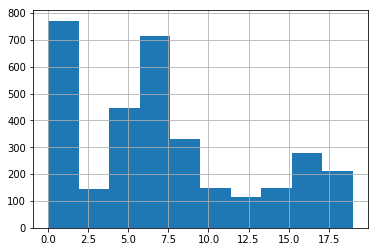

In [43]:
comp['clusters'].hist()

In [44]:
pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
            .style.background_gradient(axis=1)

In [45]:
from sklearn.metrics import *

In [46]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [49]:
(
    purity_score(comp['intent'], comp['clusters']),
    silhouette_score(X, comp['clusters']),
    homogeneity_score(comp['intent'], comp['clusters']),
    completeness_score(comp['intent'], comp['clusters']),
)

(0.2775929845781675,
 0.3378429970929738,
 0.16861812076310362,
 0.18844878845374577)

In [350]:
np.mean([


0.044,
0.071,
0.079


])

0.06466666666666666

In [51]:
np.mean([
    purity_score(comp['intent'], comp['clusters']),
    silhouette_score(X, comp['clusters']),
    homogeneity_score(comp['intent'], comp['clusters']),
    completeness_score(comp['intent'], comp['clusters']),
])

0.24312572272199767

In [90]:
comp[comp['clusters']==0]['text'].unique()

array(['i do buy a four pack every night after work',
       'when i was drinking vodka came 1st 2nd 3rd',
       "when i say drinking it's either four cans or half a bottle of wine each week evening",
       'if i dont drink for a day or two, i feel fine in myself',
       "i'm a drunk", 'i had two attemps at reducing my drinking',
       'i have a love of alcohol', 'i am a true drinker',
       'i usually start drinking at 3pm every day and by 11pm the vodka is gone',
       'i am a functioning alcoholic',
       'i was anorexic and bulimic during my 20 up to my 40',
       'i am in the process of tapering from suboxone long-term use',
       'i have been back and forth with suboxone',
       "i've been giving myself straight dopamine for over a year and abruptly stopped",
       'i am in the process of getting off of tramadol',
       'i am suppose to be nicotine free for 2-3 months',
       'just been on the patch for 4 days', 'i really do love smoking',
       'i’ve not had a ciga

## Quick easy classifier

- 10 fold cross validation on 100 examples from labelled data
- Feed forward network
- Input = sequence of word representations

In [52]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def balanced_sample_maker(X, y, sample_size, random_seed=42):
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    data_train=X[balanced_copy_idx]
    labels_train=y[balanced_copy_idx]
    if  ((len(data_train)) == (sample_size*len(uniq_levels))):
        print('number of sampled example ', sample_size*len(uniq_levels), 'number of sample per class ', sample_size, ' #classes: ', len(list(set(uniq_levels))))
    else:
        print('number of samples is wrong ')

    labels, values = zip(*Counter(labels_train).items())
    print('number of classes ', len(list(set(labels_train))))
    check = all(x == values[0] for x in values)
    print(check)
    if check == True:
        print('Good all classes have the same number of examples')
    else:
        print('Repeat again your sampling your classes are not balanced')
    indexes = np.arange(len(labels))
    width = 0.5
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()
    return data_train,labels_train

number of sampled example  2000 number of sample per class  100  #classes:  20
number of classes  20
True
Good all classes have the same number of examples


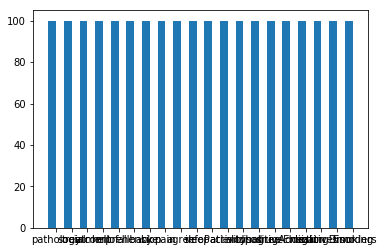

In [53]:
X_train,y_train=balanced_sample_maker(X,y,100)

In [54]:
bad_df = y.index.isin(y_train.index)
X_test = pd.DataFrame(X)[~bad_df]
y_test = data[~bad_df]['intent']

In [55]:
X_test.shape

(1859, 150)

In [56]:
from sklearn.svm import SVC

In [57]:
clf = SVC(kernel='linear', C=1, random_state=0).fit(X_train, y_train)

In [58]:
clf.score(X_test, y_test)

0.34965034965034963

In [59]:
clf.predict(X_test[:40])

array(['treatment', 'pathology', 'alcohol', 'alcohol', 'risk', 'risk',
       'alcohol', 'risk', 'alcohol', 'fallback', 'eatingDisorders',
       'drugAddiction', 'alcohol', 'activity', 'risk', 'drugAddiction',
       'risk', 'risk', 'bye', 'alcohol', 'pathology', 'eatingDisorders',
       'risk', 'incomprehension', 'treatment', 'risk', 'eatingDisorders',
       'risk', 'alcohol', 'sleep', 'risk', 'hello', 'eatingDisorders',
       'pathology', 'eatingDisorders', 'sleep', 'eatingDisorders',
       'pathology', 'sleep', 'fallback'], dtype=object)

In [60]:
from sklearn.model_selection import cross_val_score

In [61]:
cv_scores = cross_val_score(clf, X_test, y_test, cv=10) 

In [62]:
cv_scores

array([0.38659794, 0.42487047, 0.34375   , 0.46315789, 0.45212766,
       0.36898396, 0.43169399, 0.42541436, 0.375     , 0.36571429])

In [63]:
print('{:2.3} + {:2.3}%'.format(np.mean(cv_scores), np.std(cv_scores)))

0.404 + 0.0387%


In [384]:
from sklearn.metrics import confusion_matrix

In [64]:
clf_res = pd.DataFrame([clf.predict(X_test), y_test]).T
clf_res.columns = ['class', 'intent']

In [65]:
cm = pd.DataFrame(confusion_matrix(clf_res['intent'], clf_res['class']), 
             index=clf.classes_, columns=clf.classes_)
    #.style.background_gradient(axis=1)
#index = true labels, 

In [66]:
cm.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '120px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(180deg)'),
                        ])]
).background_gradient(axis=1)

,activity,agree,alcohol,bye,disagree,drugAddiction,eatingDisorders,fallback,hello,incomprehension,infoPatient,negativeEmo,pain,pathology,positiveEmo,risk,sleep,smoking,social,treatment
activity,30,0,0,0,2,1,1,6,1,3,1,0,7,8,0,10,11,2,1,14
agree,6,2,0,1,16,0,0,1,7,2,0,0,0,0,0,1,1,0,0,9
alcohol,2,0,17,2,0,2,3,1,2,1,0,0,1,2,0,10,4,0,0,4
bye,4,1,2,6,15,0,0,1,8,2,0,0,0,0,0,1,0,0,0,6
disagree,4,0,0,0,17,0,0,0,0,3,0,0,0,0,1,0,9,0,0,9
drugAddiction,10,4,3,0,4,10,3,4,2,4,1,5,5,8,1,21,6,9,1,16
eatingDisorders,3,2,2,1,0,0,30,3,1,0,4,1,0,8,1,8,9,3,0,3
fallback,3,1,0,1,15,0,0,1,1,0,0,0,0,2,0,0,0,0,0,14
hello,2,2,0,4,8,0,0,2,5,0,0,0,0,2,0,0,2,0,2,19
incomprehension,3,0,0,0,3,0,0,2,1,17,2,0,0,4,0,1,2,0,0,11


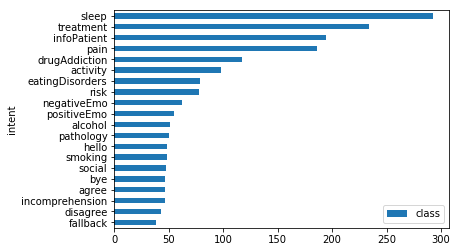

In [158]:
clf_res.groupby('intent').count().sort_values('class').plot(kind='barh')

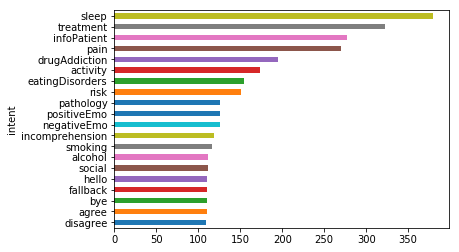

In [155]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

sentences embeddings

1. biLSTM
2. CNN
3. Emlo

different clustering models  as evaluation

purity + metrics

classification on obrained features

one-shot


** Further experiments with Sentence Representations

- use bidirectional LSTM to represent sentences
Each iput word is represented by concatenation of LDA and Word2Vec vectors

- use convolutional network 
Each iput word is represented by concatenation of LDA, Word2Vec vectors  and position information

